In [2]:
import numpy as np
import os, glob, tqdm, random, math, cv2
from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from PIL import ImageFont, ImageDraw, Image, ImageOps
import matplotlib.pyplot as plt

In [3]:
# set source work dir
labeled_data = '/home/alex/poker/пересланные скриншоты/GG_TrainDataset_cards_2+1_1'
webp = sorted(glob.glob(os.path.join(labeled_data, '*webp')))
xmls = sorted(glob.glob(os.path.join(labeled_data, '*.xml')))
print (len(webp), len(xmls),\
       os.path.basename(webp[0]),\
       os.path.basename(xmls[0]))

262 262 frame_2020.10.26_5_19_6_208.webp frame_2020.10.26_5_19_6_208.xml


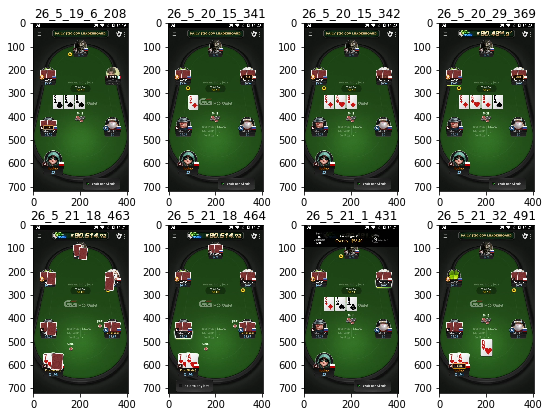

In [5]:
# check data
fig, axs = plt.subplots(2, 4, figsize=(9.3, 6.8))
for i in range(4):    
    axs[0, i].set_title(os.path.basename(webp[i].split('.')[-2]))
    axs[0, i].imshow(Image.open(webp[i]))    
    
for i in range(4):    
    axs[1, i].set_title(os.path.basename(webp[i+4]).split('.')[-2])
    axs[1, i].imshow(Image.open(webp[i+4]))

In [6]:
# check and create main ds folders
def check_esists(dir_path):
    if os.path.exists(dir_path) == False:
        os.mkdir(dir_path)
    else:
        pass
        #print ('folder '+ str(os.path.basename(dir_path))+\
         #      ' already exists.')

work_dir = '/home/alex/poker/пересланные скриншоты/work_dir'
big_suits = os.path.join(work_dir, 'SuitsBig')
small_suits = os.path.join(work_dir, 'SuitsSmall')
rangs = os.path.join(work_dir, 'Rangs')
dirs_list = [big_suits, small_suits, rangs]

for i in dirs_list:
    check_esists(i)    

In [7]:
def clean_script():
    jpg = glob.glob(os.path.join(work_dir,'*/*/*.jpg'))
    pbm = glob.glob(os.path.join(work_dir, '*/*/*.pbm'))
    for i in jpg+pbm:
        os.remove(i)
    print ('remove '+str(len(jpg)+len(pbm))+' images.')
    
clean_script()

remove 0 images.


In [8]:
def create_bb_dict(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    b_boxes = {}
    for i in root:
        if i.tag == 'object' and i[0].text == 'cards':            
            for el in i:
                values = []
                if el.tag == 'attributes':                    
                    value = el.text.split('=')[1]  
                    values += [value]                    
                elif el.tag == 'polygon':  
                    coord = []
                    for j in el:                       
                        if j.tag == "pt":
                            point = []
                            for c in j:                            
                                if c.tag == 'x'  or c.tag == 'y':                              
                                    point += [int(float(c.text))]  
                            coord+= [point]                    
            b_boxes[values[-1]] = (coord[0][0], coord[0][1], coord[2][0],coord[2][1])
            
    return b_boxes                        

In [9]:
for i in xmls[0:3]:
    name = os.path.basename(i)
    print (name, create_bb_dict(i))

frame_2020.10.26_5_19_6_208.xml {'♠': (192, 338, 218, 365), '♣': (99, 337, 127, 368), '3♣': (88, 310, 104, 348), 'q♠': (179, 310, 195, 347), '8♠': (134, 311, 149, 347)}
frame_2020.10.26_5_20_15_341.xml {'♦': (102, 341, 127, 370), '6♦': (90, 313, 105, 351)}
frame_2020.10.26_5_20_15_342.xml {'♦': (100, 338, 126, 366), '♥': (147, 338, 176, 366), '5♥': (135, 311, 153, 346), '6♦': (184, 310, 198, 347), '8♦': (88, 309, 103, 347)}


In [10]:
def cut_border(some_array): 
    border = []
    for i in range(len(some_array)):
        if True in some_array[i]:
            border += [i]
    maximum = max(border)+1
    if min(border)-1>=0:
        minimum =min(border)-1
    else:
        minimum = min(border)      
    return (minimum, maximum)

def fill_cont(some_contour, background_shape):
    background = np.zeros(background_shape)
    image = cv2.fillPoly(background, pts =[some_contour],\
                             color=(255,255,255)) 
    image = image.astype(bool)
    border = cut_border(image)
    image = image[border[0]:border[1]]
    image = Image.fromarray(image)
    return image, border      
    
def split_array(some_arr):    
    up_border = int(len(some_arr)*0.2)
    down_border = int(len(some_arr)*0.85)
    middle = [i for i in range(up_border, down_border)]
        #print (up_border, down_border)
    split = False
    for i in range(up_border, down_border):
        if sum(some_arr[i]) == 0:
            split = True        
    if split == True:
        return some_arr
    elif split == False:
        split_array = []
        for i in range(len(some_arr)):
            if i in middle:
                if sum(some_arr[i])< 766:
                    split_array += [[0]*len(some_arr[i])]
                else:
                    split_array += [some_arr[i]]
            else:
                split_array += [some_arr[i]]
        split_array = np.asarray(split_array)
        split_array = split_array.astype('uint8')
        return split_array
    
def brg_to_gray(some_array):
    gray = cv2.cvtColor(some_array, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    img_arr = Image.fromarray(binary)
    img_arr = ImageOps.grayscale(img_arr)
    img_arr = ImageOps.invert(img_arr)
    img_arr = np.asarray(img_arr)
    return img_arr

def find_contours(array):
    return cv2.findContours(array,cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

In [11]:
def jpg_to_pbm_single(input_array, save_path):    
    img_arr = brg_to_gray(input_array)
    contours, hierarchy = find_contours(img_arr)
    shape = img_arr.shape
    quadr = (np.zeros(shape))
    c = max(contours, key = cv2.contourArea)
    image = cv2.fillPoly(quadr, pts =[c], color=(255,255,255))    
    image = image.astype(bool)
    image = Image.fromarray(image)
    image.save(save_path)    
    
def jpg_to_pbm_double(input_array, rang_save_path, suit_save_path):
    img_arr = brg_to_gray(input_array)
    img_arr = split_array(img_arr)
    contours, hierarchy = find_contours(img_arr)
    shape = img_arr.shape
    cont = sorted(contours, key = cv2.contourArea)
    first = cont[-1]
    second = cont[-2]
    first_setting = fill_cont(first, shape)
    second_setting = fill_cont(second,shape) 
    if first_setting[1][0] < second_setting[1][0]:
        #first  is suit   
        upper_mask = (first_setting[0]) # pil img pbm
        lower_mask = (second_setting[0]) # pil img pbm  )
        upper_image = Image.fromarray(input_array\
                            [first_setting[1][0]:first_setting[1][1]])
        lower_image = Image.fromarray(input_array\
                            [second_setting[1][0]:second_setting[1][1]])
    elif first_setting[1][0] > second_setting[1][0]:
        #first  is suit   
        upper_mask = (second_setting[0]) # pil img pbm
        lower_mask = (first_setting[0]) # pil img pbm  )
        upper_image = Image.fromarray(input_array\
                            [second_setting[1][0]:second_setting[1][1]])
        lower_image = Image.fromarray(input_array\
                            [first_setting[1][0]:first_setting[1][1]])    
    upper_mask.save(rang_save_path+'.pbm')
    upper_image.save(rang_save_path+'.jpg')
    lower_mask.save(suit_save_path+'.pbm')
    lower_image.save(suit_save_path+'.jpg')
      
def jpeg_to_pb_triple(input_array, rang_save_path,suit_save_path):
    #input_test = np.asarray(test_crop)
    img_arr = brg_to_gray(input_array)
    contours, hierarchy = find_contours(img_arr)
    shape = img_arr.shape
    cont = sorted(contours, key = cv2.contourArea)
    first_setting = fill_cont(cont[-1], shape)
    second_setting = fill_cont(cont[-2],shape)
    third_setting = fill_cont(cont[-3], shape)
    up_marker = max(first_setting[1][0], \
                    second_setting[1][0], third_setting[1][0])
    down_marker = min(first_setting[1][0], \
                    second_setting[1][0], third_setting[1][0])    
    settings = [first_setting[1], second_setting[1], third_setting[1]]     
    for i in settings:
        if i[0] == down_marker:
            upper_mask = img_arr[i[0]:i[1]]
            upper_mask = upper_mask.astype('bool')
            upper_mask = Image.fromarray(upper_mask)
            upper_image = Image.fromarray(input_array[i[0]:i[1]])
        elif i[0] == up_marker:
            lower_mask = img_arr[i[0]:i[1]]
            contours, hierarchy = find_contours(lower_mask)
            shape = lower_mask.shape
            quadr = (np.zeros(shape))
            c = max(contours, key = cv2.contourArea)
            lower_mask = cv2.fillPoly(quadr, pts =[c], color=(255,255,255))    
            lower_mask = lower_mask.astype(bool) 
            lower_mask = Image.fromarray(lower_mask)           
            lower_image = Image.fromarray(input_array[i[0]:i[1]])        
    upper_mask.save(rang_save_path+'.pbm')
    upper_image.save(rang_save_path+'.jpg')
    lower_mask.save(suit_save_path+'.pbm')
    lower_image.save(suit_save_path+'.jpg')

In [12]:
def create_crops_and_masks(INDEX):
    b_boxes = create_bb_dict(xmls[INDEX])
    suits = ['♠','♦','♣','♥']
    drop_symb = ['10', 'aa']
    keys = list(b_boxes.keys())
    image_path = webp[INDEX]
    for j in range(len(keys)):
        i = keys[j]
        if len(i) == 1 and i in suits:      
            save_dir = os.path.join(big_suits, i)      
            unique_name = os.path.basename(image_path).split('.')[-2]\
                +'_'+str(j)+i  # unique name for this pair        
            save_path = os.path.join(save_dir, unique_name) # unique path for this jpg-pbm pair      
            check_esists(save_dir)    #  
            coordinates = b_boxes[i] # get bb coordinate to crop
            source_image = Image.open(image_path)  
            crop_image = source_image.crop(coordinates)
            crop_image.save(save_path+'.jpg') # save crop jpg        
            crop_array = np.asarray(crop_image) # prepare to pbm convertion
            save_mask_path = (save_path+'.pbm')
            jpg_to_pbm_single(crop_array, save_mask_path) # save mask pbm        

        elif len(i) == 2 and i not in drop_symb:          
            rang = i[0:1]
            suit = i[1:2]        
            rang_save_dir = os.path.join(rangs, rang)
            suit_save_dir = os.path.join(small_suits, suit)
            check_esists(rang_save_dir)
            check_esists(suit_save_dir)
            unique_name = os.path.basename(image_path).split('.')[-2]\
                +'_'+str(j)  # unique name for this pair 

            rang_save_path = os.path.join(rang_save_dir, unique_name+rang)
            suit_save_path = os.path.join(suit_save_dir, unique_name+suit) 
            coordinates = b_boxes[i] # get bb coordinate to crop
            source_image = Image.open(image_path)  
            crop_image = source_image.crop(coordinates)
            crop_array = np.asarray(crop_image)
            jpg_to_pbm_double(crop_array,rang_save_path, suit_save_path)
        elif len(i) == 3 and i.startswith('10'):
            rang = i[0:2]
            suit = i[2:3]
            #print (rang,suit)
            rang_save_dir = os.path.join(rangs, rang)
            suit_save_dir = os.path.join(small_suits, suit)
            check_esists(rang_save_dir)
            check_esists(suit_save_dir)
            unique_name = os.path.basename(image_path).split('.')[-2]\
                +'_'+str(j)  # unique name for this pair 
            rang_save_path = os.path.join(rang_save_dir, unique_name+rang)
            suit_save_path = os.path.join(suit_save_dir, unique_name+suit)  
            coordinates = b_boxes[i] # get bb coordinate to crop
            source_image = Image.open(image_path)  
            crop_image = source_image.crop(coordinates)
            crop_array = np.asarray(crop_image)
            jpeg_to_pb_triple(crop_array,rang_save_path, suit_save_path)    
        else:
            pass

In [13]:
clean_script()

remove 0 images.


In [14]:
for i in tqdm.tqdm_notebook(range(len(xmls))):   
    try:
        #print (i)
        create_crops_and_masks(i)
    except UnboundLocalError: # except vertical pairs
        print (i, end = ' ')

21 34 50 115 


In [15]:
jpg_count = len(glob.glob(os.path.join(work_dir,'*/*/*.jpg')))
pbm_count = len(glob.glob(os.path.join(work_dir,'*/*/*.pbm')))
print (jpg_count,pbm_count)

2332 2332
